# Average Entanglement Entropy

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.extensions import UnitaryGate
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.visualization import array_to_latex
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit import Aer
from sympy import factorint
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import pi
from sympy import *
import random
from random import sample
import pandas as pd
import math

In [4]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return y
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 

In [5]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix_0 = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix_0[j][i]=1
             
    for ii in range(N, dim):
        matrix_0[ii][ii] = 1
             
    #matrix = linalg.matrix_power(matrix, 2**power) #possibly dimezzare op. number
    temp = matrix_0
    for iii in range(power):
        matrix = np.dot(temp, temp)
        temp = matrix
        
    U = UnitaryGate(temp)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [6]:
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [7]:
def structure(y, N, qubits):

    n = math.ceil(math.log(N,2))
    control = QuantumRegister(2*n, 'r1')
    target  = QuantumRegister(n, 't1')
    classic = ClassicalRegister(2*n, 'c')

    circuit = QuantumCircuit(control, target, classic)

    size = len(qubits)
    label = 0
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
    circuit.barrier(3*n - 1)

    circuit.h(range(2*n))
    circuit.x(2*n + n -1)

    label += 1

    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

    for q in range(2*n):
        label += 1
        circuit.append(mod_exp(n, y, N, q), [q] + [i+2*n for i in range(n)]) 
        circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

    circuit.append(qft_dagger(2*n), range(2*n)) 
    label += 1
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])


    circuit.measure(control, classic)
    label += 1
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
    
    return circuit

In [8]:
runs = 20
partition = 4
y = 4
N = 21

rho_step = 12                #number of rhos to consider +1!
somma = np.zeros(rho_step)

n = math.ceil(math.log(N,2))

for j in range(runs): 
    
    qubit = random.sample(range(0, 2*n), partition)
    print(qubit)
    circuit = structure(y, N, qubit)
    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(circuit, aer_sim)
    qobj = assemble(t_qc)                                
    results = aer_sim.run(qobj, shots = 1).result()
    counts = results.get_counts()

    labels = []
    for i in range(len(counts)):
        labels.append(int(list(counts.keys())[i], 2))

    negativities = []
    for i in range(rho_step):
        density_matrix = results.data()['pho_%.1f' % (i)]
        density_matrix_op = density_matrix.to_operator()
        density_matrix_tr = density_matrix_op.transpose()
        negativities.append( linalg.norm(density_matrix_tr, 1) - 1 )
        
    print(j, negativities)
    for i in range(len(negativities)):
        somma[i] = somma[i] + negativities[i]
    
    negativities = 0
    counts = 0
    results = 0
    density_matrix = 0
    circuit = 0
    t_qc = 0
    qobj = 0
     
j += 1



[2, 7, 0]
0 [2.220446049250313e-16, 8.881784197001252e-16, -0.4999999999986575, -0.4999999999986575, -0.49999999999755307, -0.49999999999755307, -0.49999999999755307, -0.49999999999755307, -0.49999999999755307, -0.6249999999947637, -0.6249999999947637, -0.6249999999947637]
[0, 4, 9]
1 [2.220446049250313e-16, 6.661338147750939e-16, -0.49999999999871303, -0.49999999999871303, -0.49999999999871303, -0.49999999999871303, -0.4999999999960135, -0.4999999999960135, -0.4999999999960135, -0.4999999999960135, -0.4999999999960135, -0.624999999993644]


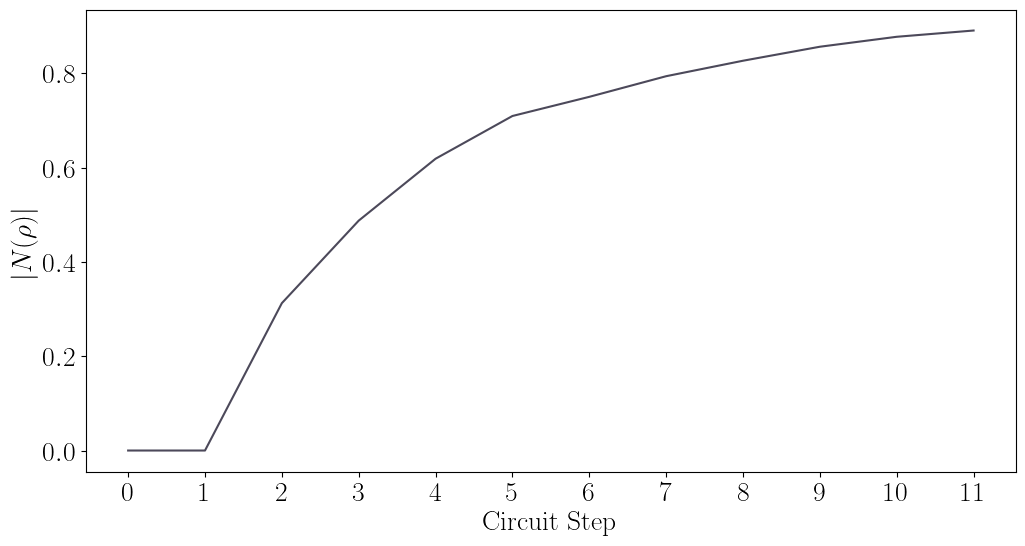

In [15]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 6))
params = {'text.usetex' : True, 'font.size' : 20, 'font.family' : 'serif'}
plt.rcParams.update(params)

reps = 20
media = [-8.992806499463768e-15, -1.8762769116165146e-14, 6.249999999983573, 9.74999999996751, 12.374999999946318, 14.187499999926523, 14.999999999910552, 15.874999999898876, 16.53124999989106, 17.12499999987014, 17.546874999857998, 17.812499999845123]
xs = []
#media = []
#for i in range(len(somma)):
#    media.append(-somma[i]/2)

for i in range(len(media)):
    media[i] = media[i]/reps
    xs.append(i)

plt.xticks(xs)
plt.xlabel('Circuit Step')
plt.ylabel(r"$|N(\rho)|$")
plt.plot(media, color = '#4C495A')
plt.savefig('shor_ent_partitions4.pdf', format = 'pdf')


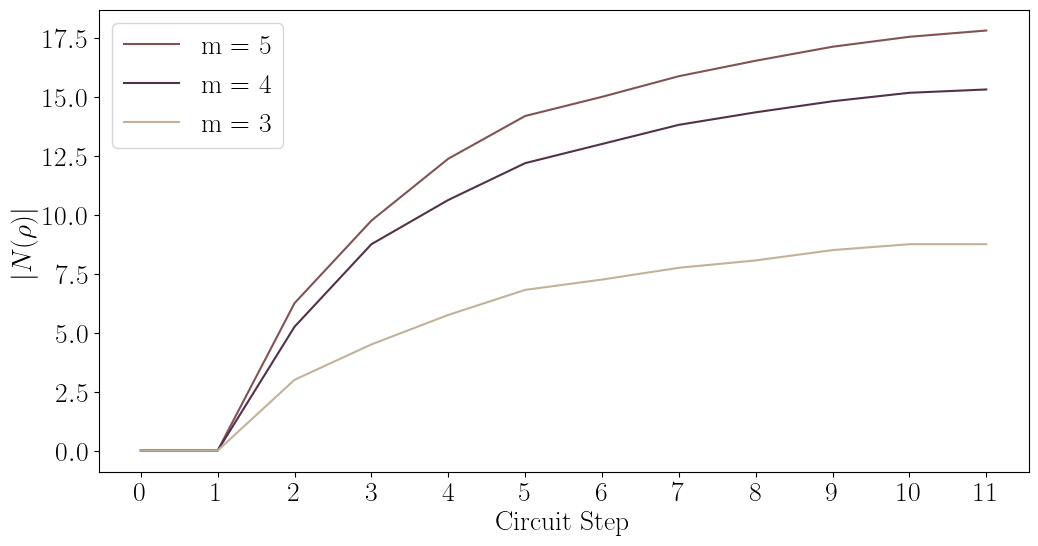

In [16]:
plt.rc('figure', figsize=(12, 6))
params = {'text.usetex' : True, 'font.size' : 20, 'font.family' : 'serif'}
plt.rcParams.update(params)
import seaborn as sns


colors = ['#815355','#523249','#C3B299'  ]
cmap = plt.get_cmap("twilight")
df = pd.DataFrame({"media_20shots_N21_y4_size3": [-8.992806499463768e-15, -1.8762769116165146e-14, 6.249999999983573, 9.74999999996751, 12.374999999946318, 14.187499999926523, 14.999999999910552, 15.874999999898876, 16.53124999989106, 17.12499999987014, 17.546874999857998, 17.812499999845123],
                   "media_20shots_N21_y4_size5" : [-7.66053886991358e-15, -1.509903313490213e-14, 5.249999999986203, 8.74999999997014, 10.624999999953683, 12.187499999938273, 12.99999999992287, 13.812499999912593, 14.343749999907985, 14.812499999889386, 15.171874999877737, 15.312499999866038],
                   "media_20shots_N21_y4_size4" : [-3.9968028886505635e-15, -9.2148511043888e-15, 2.999999999992106, 4.499999999985563, 5.749999999974862, 6.812499999964368, 7.24999999995721, 7.7499999999493445, 8.062499999946658, 8.499999999934833, 8.749999999929294, 8.749999999920806]
                  })
x = df.index
for i, col in enumerate(df.columns):
    plt.plot(x, df[col], color=colors[i], label=col)

plt.xticks(xs)
plt.ylabel(r"$|N(\rho)|$")
plt.xlabel('Circuit Step')
legend = plt.legend(['m = 5','m = 4', 'm = 3'])
cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)

plt.savefig('shor_ent_partitions_sizes.pdf', format = 'pdf')

